In [2]:
import pandas as pd
import numpy as np
import random
import datetime
import uuid
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly as px

In [3]:
import pandas as pd
import numpy as np
import random
import datetime
import uuid

def generate_sales_data(n=2000000):
    """
    Generates a Pandas DataFrame with n rows of sales data,
    including intentional errors for data cleaning practice.
    """
    print(f"Generating {n} rows of data...")

    # --- 1. Generate Core Data (Vectorized for Speed) ---
    
    # Order IDs: UUIDs
    print("Generating UUIDs...")
    order_ids = [str(uuid.uuid4()) for _ in range(n)]
    
    # Dates: Random datetime objects within last 2 years
    print("Generating Dates...")
    base_date = datetime.datetime.now()
    # Generate random seconds offset for 2 years (approx)
    seconds_offset = np.random.randint(0, 63072000, n)
    # Modified: Return YYYY-MM-DD strings directly
    order_dates = [(base_date - datetime.timedelta(seconds=int(x))).strftime('%Y-%m-%d') for x in seconds_offset]
    
    # --- Customer Generation (Consistent Profiles) ---
    print("Generating Customers...")
    # Customers (Simulate fewer unique customers than orders)
    num_customers = n // 5  # e.g., 400k unique customers implies avg 5 orders per customer
    unique_customer_ids = np.arange(1000, 1000 + num_customers)
    
    # Realistic LatAm Names Components
    first_names = ["Juan", "María", "Pedro", "Ana", "Luis", "Carmen", "Carlos", "Josefa", "Jorge", "Isabel", 
                   "Miguel", "Paula", "Francisco", "Elena", "Antonio", "Luisa", "David", "Raquel", "Javier", "Lucía",
                   "Sofía", "Mateo", "Valentina", "Santiago", "Camila", "Sebastián", "Isabella", "Benjamín", "Felipe", "Mariana"]
    last_names = ["González", "Rodríguez", "Pérez", "Fernández", "López", "García", "Martínez", "Sánchez", 
                  "Romero", "Díaz", "Muñoz", "Rojas", "Silva", "Torres", "Vargas", "Ramírez", "Flores", "Acosta",
                  "Gomez", "Morales", "Rivera", "Castillo", "Ortiz", "Gutierrez", "Chavez", "Castro", "Ruiz"]

    # Allowed Countries with Population-based Weights (Approx)
    countries = ["Brasil", "México", "Colombia", "Argentina", "Perú", "Chile", "Ecuador", "Uruguay"]
    # Approx weights based on population (very rough relative scale)
    country_weights = [0.40, 0.25, 0.10, 0.09, 0.07, 0.04, 0.03, 0.02]
    
    # Generate profiles for unique customers
    # We use numpy for fast random choice
    u_firsts = np.random.choice(first_names, num_customers)
    u_lasts = np.random.choice(last_names, num_customers)
    u_countries = np.random.choice(countries, num_customers, p=country_weights)
    
    # Create a mapping DataFrame for customers
    df_customers = pd.DataFrame({
        "customer_id": unique_customer_ids,
        "customer_first": u_firsts,
        "customer_last": u_lasts,
        "customer_country": u_countries
    })

    # Country Code Mapping
    country_code_map = {
        "Brasil": "BRA", "México": "MEX", "Colombia": "COL", "Argentina": "ARG", 
        "Perú": "PER", "Chile": "CHL", "Ecuador": "ECU", "Uruguay": "URY"
    }
    df_customers["country_code"] = df_customers["customer_country"].map(country_code_map)
    
    df_customers["customer_name"] = df_customers["customer_first"] + " " + df_customers["customer_last"]
    
    # Vectorized email generation
    df_customers["customer_email"] = (
        df_customers["customer_first"].str.lower() + "." + 
        df_customers["customer_last"].str.lower() + 
        "_" + df_customers["customer_id"].astype(str) + 
        "@example.com"
    )

    # City generation 
    city_map = {
        "Chile": ["Santiago", "Valparaíso", "Concepción", "La Serena", "Antofagasta", "Temuco", "Rancagua"],
        "Argentina": ["Buenos Aires", "Córdoba", "Rosario", "Mendoza", "La Plata", "Tucumán", "Mar del Plata"],
        "Uruguay": ["Montevideo", "Salto", "Ciudad de la Costa", "Paysandú", "Maldonado"],
        "Perú": ["Lima", "Arequipa", "Trujillo", "Chiclayo", "Cusco", "Piura", "Iquitos"],
        "Colombia": ["Bogotá", "Medellín", "Cali", "Barranquilla", "Cartagena", "Cúcuta", "Bucaramanga"],
        "Brasil": ["São Paulo", "Rio de Janeiro", "Brasília", "Salvador", "Fortaleza", "Belo Horizonte", "Manaus"],
        "Ecuador": ["Guayaquil", "Quito", "Cuenca", "Santo Domingo", "Ambato"],
        "México": ["Ciudad de México", "Guadalajara", "Monterrey", "Puebla", "Tijuana", "León", "Juárez"]
    }
    
    # Assign a random city from the country for each customer
    def get_city(country):
        return np.random.choice(city_map.get(country, ["Unknown"]))
    
    print("Mapping cities to customers...")
    df_customers["customer_city"] = df_customers["customer_country"].apply(get_city)
    
    # Address - randomized
    df_customers["customer_address"] = [f"{random.randint(1,9999)} Calle {random.choice(['Principal', 'Secundaria', 'Norte', 'Sur', 'Este', 'Oeste', 'Los Alamos', 'Los Pinos'])}" for _ in range(num_customers)]

    # Distribute customers to orders
    print("Assigning orders to customers...")
    chosen_customer_ids = np.random.choice(unique_customer_ids, n)
    
    # Map customers to countries for the orders
    customer_country_map = df_customers.set_index("customer_id")["customer_country"]
    # Efficiently map: lookups random array using pandas index
    # We might need to ensure chosen_customer_ids are series/array to map
    order_countries = customer_country_map.loc[chosen_customer_ids].values
    
    # --- Products Generation (Stratified by Country) ---
    # Enhanced product list with realistic prices and weights
    products = [
        {"id": "P001", "name": "Laptop Pro", "cat": "Electronics", "price": 1200.00, "weight": 2.5},
        {"id": "P002", "name": "Smartphone X", "cat": "Electronics", "price": 800.00, "weight": 0.2},
        {"id": "P003", "name": "Wireless Mouse", "cat": "Accessories", "price": 25.50, "weight": 0.1},
        {"id": "P004", "name": "Mechanical Keyboard", "cat": "Accessories", "price": 150.00, "weight": 1.2},
        {"id": "P005", "name": "Monitor 27in", "cat": "Electronics", "price": 300.00, "weight": 5.0},
        {"id": "P006", "name": "Coffee Maker", "cat": "Home", "price": 85.00, "weight": 3.0},
        {"id": "P007", "name": "Blender", "cat": "Home", "price": 45.00, "weight": 2.2},
        {"id": "P008", "name": "Office Chair", "cat": "Furniture", "price": 200.00, "weight": 15.0},
        {"id": "P009", "name": "Running Shoes", "cat": "Fashion", "price": 120.00, "weight": 0.8},
        {"id": "P010", "name": "T-Shirt", "cat": "Fashion", "price": 20.00, "weight": 0.2},
        {"id": "P011", "name": "Smart TV 55in", "cat": "Electronics", "price": 600.00, "weight": 12.0},
        {"id": "P012", "name": "Headphones NoiseCancelling", "cat": "Electronics", "price": 250.00, "weight": 0.3},
        {"id": "P013", "name": "Gaming Console", "cat": "Electronics", "price": 500.00, "weight": 3.5},
        {"id": "P014", "name": "Microwave Oven", "cat": "Home", "price": 150.00, "weight": 10.0},
        {"id": "P015", "name": "Hair Dryer", "cat": "Home", "price": 35.00, "weight": 0.6},
        {"id": "P016", "name": "Sofa 3-Seater", "cat": "Furniture", "price": 800.00, "weight": 45.0},
        {"id": "P017", "name": "Bookshelf", "cat": "Furniture", "price": 120.00, "weight": 18.0},
        {"id": "P018", "name": "Jeans", "cat": "Fashion", "price": 45.00, "weight": 0.5},
        {"id": "P019", "name": "Sneakers", "cat": "Fashion", "price": 85.00, "weight": 0.7},
        {"id": "P020", "name": "Backpack", "cat": "Accessories", "price": 55.00, "weight": 0.4},
    ]
    
    # Define Weights Profiles
    # Profile 1: Tech Enthusiasts (Chile, Uruguay)
    weights_tech = np.array([0.15, 0.15, 0.05, 0.08, 0.10, 0.02, 0.02, 0.05, 0.05, 0.02, 0.10, 0.08, 0.10, 0.01, 0.01, 0.005, 0.005, 0.0, 0.0, 0.0])
    weights_tech /= weights_tech.sum()

    # Profile 2: Fashion/Home (Argentina, Colombia, Peru)
    weights_home = np.array([0.02, 0.05, 0.02, 0.01, 0.02, 0.10, 0.10, 0.05, 0.10, 0.15, 0.05, 0.02, 0.03, 0.08, 0.08, 0.02, 0.02, 0.05, 0.03, 0.0])
    weights_home /= weights_home.sum()

    # Profile 3: Balanced/General (Brasil, Mexico, Ecuador)
    weights_balanced = np.ones(len(products)) / len(products)
    
    print("Generating Products (Weighted by Country)...")
    
    # Pre-allocate arrays
    prod_choices = np.empty(n, dtype=object)
    
    # Vectorized application of weights
    # We'll split indices by country group to apply random choice efficiently
    
    # Group Countries
    countries_tech = ["Chile", "Uruguay"]
    countries_home = ["Argentina", "Colombia", "Perú"]
    countries_balanced = ["Brasil", "México", "Ecuador"]
    
    # Masks
    mask_tech = np.isin(order_countries, countries_tech)
    mask_home = np.isin(order_countries, countries_home)
    mask_balanced = np.isin(order_countries, countries_balanced)
    
    # Generate for Tech group
    if np.any(mask_tech):
        n_tech = np.sum(mask_tech)
        prod_choices[mask_tech] = np.random.choice(products, n_tech, p=weights_tech)
        
    # Generate for Home group
    if np.any(mask_home):
        n_home = np.sum(mask_home)
        prod_choices[mask_home] = np.random.choice(products, n_home, p=weights_home)
        
    # Generate for Balanced group
    if np.any(mask_balanced):
        n_bal = np.sum(mask_balanced)
        prod_choices[mask_balanced] = np.random.choice(products, n_bal, p=weights_balanced)
    
    # Use fallback for any missing holes (shouldn't be any, but good practice)
    mask_filled = mask_tech | mask_home | mask_balanced
    if not np.all(mask_filled):
        n_miss = n - np.sum(mask_filled)
        prod_choices[~mask_filled] = np.random.choice(products, n_miss) # Uniform fallback

    # Extract details
    prod_ids = [p["id"] for p in prod_choices]
    prod_names = [p["name"] for p in prod_choices]
    prod_cats = [p["cat"] for p in prod_choices]
    prod_prices = np.array([p["price"] for p in prod_choices])
    prod_weights = np.array([p["weight"] for p in prod_choices])
    
    # Quantities - Vary slightly by profile too? Let's keep quantities simple but maybe higher for 'Home' items?
    # Keeping quantities random for now to avoid over-complicating.
    quantities = np.random.choice([1, 2, 3, 4, 5, 10], n, p=[0.7, 0.15, 0.1, 0.03, 0.01, 0.01])
    
    # --- New Numeric Variables ---
    print("Calculating financials...")
    # Base Amount
    total_amounts = quantities * prod_prices
    
    # Discount (0%, 5%, 10%, 20%)
    discounts_rates = np.random.choice([0.0, 0.05, 0.10, 0.20], n, p=[0.6, 0.2, 0.15, 0.05])
    discount_amounts = total_amounts * discounts_rates
    
    # Tax (Standard 19% approx for LatAm avg, simplified)
    tax_rate = 0.19
    tax_amounts = (total_amounts - discount_amounts) * tax_rate
    
    # Shipping Cost based on weight
    # Base rate + weight factor
    # Simplify: 5.00 base + 1.50 per kg
    total_weights = quantities * prod_weights
    shipping_costs = 5.00 + (total_weights * 1.50)
    
    # Final Total
    final_totals = (total_amounts - discount_amounts) + tax_amounts + shipping_costs
    
    
    # Additional Columns with Heterogeneous Distribution
    # Rule 1: High Amount (> $1000) -> Mostly Credit Card
    # Rule 2: Brazil -> High Credit Card preference
    # Rule 3: Low Amount (< $50) -> Cash/Debit/PayPal
    
    print("Generating Payment Methods (Correlated)...")
    payment_methods = np.empty(n, dtype=object)
    
    pm_opts = ["Credit Card", "Debit Card", "PayPal", "Bank Transfer"]
    
    # Probability Matrices for vectorized choice
    # We will loop through chunks or valid masks again
    
    # Mask 1: High Value
    mask_high_val = final_totals > 1000
    # Mask 2: Low Value
    mask_low_val = final_totals < 50
    # Mask 3: Brazil (High Credit Use)
    mask_brazil = order_countries == "Brasil"
    # Mask 4: Argentina (Debit/Cash heavy in this simulation)
    mask_arg = order_countries == "Argentina"
    
    # Default selection (Mid range, other countries)
    # Weights: CC 40%, DC 40%, PP 15%, BT 5%
    default_probs = [0.40, 0.40, 0.15, 0.05]
    
    # Logic Application loop (a bit manual but clear)
    # We iterate and assign based on hierarchy or just apply broadly
    
    # Let's generate a base for everyone first
    payment_methods[:] = np.random.choice(pm_opts, n, p=default_probs)
    
    # Apply Overrides
    
    # Brazil Override: CC 70%, DC 20%, PP 5%, BT 5%
    n_br = np.sum(mask_brazil)
    if n_br > 0:
        payment_methods[mask_brazil] = np.random.choice(pm_opts, n_br, p=[0.70, 0.20, 0.05, 0.05])
        
    # Argentina Override: CC 30%, DC 50%, PP 10%, BT 10%
    n_arg = np.sum(mask_arg)
    if n_arg > 0:
        payment_methods[mask_arg] = np.random.choice(pm_opts, n_arg, p=[0.30, 0.50, 0.10, 0.10])
        
    # High Value Override (Global, stronger than country? Maybe)
    # If > 1000, force shifting towards Credit Card/Transfer
    # CC 80%, BT 15%, DC 5%, PP 0%
    n_high = np.sum(mask_high_val)
    if n_high > 0:
        payment_methods[mask_high_val] = np.random.choice(pm_opts, n_high, p=[0.80, 0.05, 0.0, 0.15])
        
    # Low Value Override
    # CC 10%, DC 60%, PP 30%, BT 0%
    n_low = np.sum(mask_low_val)
    if n_low > 0:
        payment_methods[mask_low_val] = np.random.choice(pm_opts, n_low, p=[0.10, 0.60, 0.30, 0.0])

    # Delivered 40%, Shipped 30%, Processing 20%, Cancelled 10%
    shipping_statuses = np.random.choice(
        ["Delivered", "Shipped", "Processing", "Cancelled"], 
        n, 
        p=[0.40, 0.30, 0.20, 0.10]
    )
    
    # --- 2. Create DataFrame ---
    print("Assembling DataFrame...")
    
    # Create the orders DataFrame
    df_orders = pd.DataFrame({
        "order_id": order_ids,
        "order_date": order_dates,
        "customer_id": chosen_customer_ids,
        "product_id": prod_ids,
        "product_name": prod_names,
        "product_category": prod_cats,
        "quantity": quantities,
        "price_per_unit": prod_prices,
        "total_amount_gross": total_amounts,
        "discount_amount": discount_amounts,
        "tax_amount": tax_amounts,
        "shipping_cost": shipping_costs,
        "final_total_amount": final_totals,
        "payment_method": payment_methods,
        "shipping_status": shipping_statuses,
        "total_weight": total_weights
    })
    
    # Merge with customers to get customer details
    # This ensures consistency: same customer_id always has same name/email/country/city
    print("Merging with Customer Data...")
    df = pd.merge(df_orders, df_customers, on="customer_id", how="left")
    
    # Reorder columns for readability
    cols = [
        "order_id", "order_date", 
        "customer_id", "customer_name", "customer_email", "customer_country", "country_code", "customer_city", "customer_address",
        "product_id", "product_name", "product_category", "quantity",
        "price_per_unit", "total_weight", "shipping_cost",
        "total_amount_gross", "discount_amount", "tax_amount", "final_total_amount",
        "payment_method", "shipping_status"
    ]
    df = df[cols]
    
    # --- 3. Inject Errors (Dirty Data) ---
    print("Injecting dirty data...")
    
    # 3.1 Null Values - Categorical/String
    df.loc[df.sample(frac=0.05).index, "customer_email"] = np.nan
    df.loc[df.sample(frac=0.10).index, "shipping_status"] = np.nan
    df.loc[df.sample(frac=0.02).index, "customer_city"] = np.nan

    # 3.2 Null Values - Numeric (Requested)
    # Injecting NaNs into numeric columns for pedagogical variety
    print("Injecting numeric nulls...")
    # 1% nulls in tax_amount
    df.loc[df.sample(frac=0.01).index, "tax_amount"] = np.nan
    # 0.5% nulls in shipping_cost
    df.loc[df.sample(frac=0.005).index, "shipping_cost"] = np.nan
    # 0.1% nulls in total_weight
    df.loc[df.sample(frac=0.001).index, "total_weight"] = np.nan
    # 0.2% nulls in price_per_unit (critical error)
    df.loc[df.sample(frac=0.002).index, "price_per_unit"] = np.nan

    # 3.3 Logic Errors
    # Negative quantities (0.1% of data)
    err_idx_neg = df.sample(frac=0.001).index
    df.loc[err_idx_neg, "quantity"] = df.loc[err_idx_neg, "quantity"] * -1
    
    # Total amount mismatch (0.5% of data) -> Price check fail
    err_idx_math = df.sample(frac=0.005).index
    df.loc[err_idx_math, "final_total_amount"] = df.loc[err_idx_math, "final_total_amount"] * 0.5

    # 3.4 String Format Issues
    # Payment Method casing
    df["payment_method"] = df["payment_method"].apply(lambda x: x.lower() if random.random() < 0.1 else x.upper() if random.random() < 0.1 else x)
    
    # Whitespace in Product Name
    df["product_name"] = df["product_name"].apply(lambda x: f" {x} " if random.random() < 0.05 else x)

    # 3.5 Inconsistent Types (Dates) - FIXED per user request (No invalid dates)
    # We ensure order_date remains as YYYY-MM-DD string
    pass 
    
    # 3.6 Duplicates
    duplicates = df.sample(n=1000)
    df = pd.concat([df, duplicates], ignore_index=True)
    
    print(f"Dataset generated with shape: {df.shape}")
    return df

if __name__ == "__main__":
    # Generate the data
    df_sales = generate_sales_data(2000000)
    
    # Save to CSV
    output_file = "sales_data_dirty.csv"
    print(f"Saving to {output_file}...")
    df_sales.to_csv(output_file, index=False)
    print("Done!")

Generating 2000000 rows of data...
Generating UUIDs...
Generating Dates...
Generating Customers...
Mapping cities to customers...
Assigning orders to customers...
Generating Products (Weighted by Country)...
Calculating financials...
Generating Payment Methods (Correlated)...
Assembling DataFrame...
Merging with Customer Data...
Injecting dirty data...
Injecting numeric nulls...
Dataset generated with shape: (2001000, 22)
Saving to sales_data_dirty.csv...
Done!


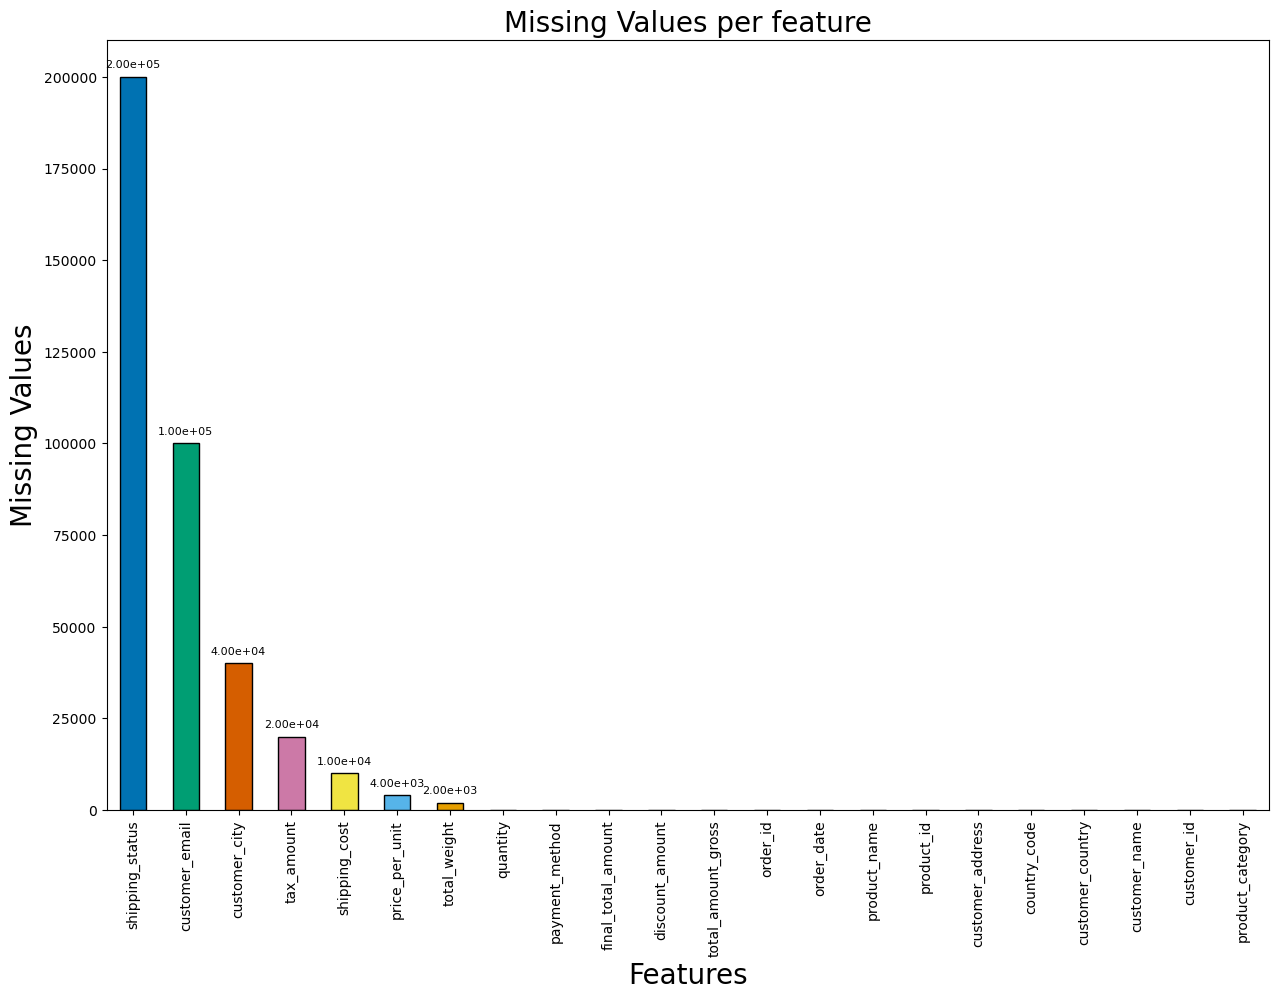

In [4]:
colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]
ax = df_sales.isna().sum().sort_values(ascending=False).plot(kind = 'bar',color = colores_hex ,figsize=(15,10), edgecolor = 'black') 
plt.title("Missing Values per feature",fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Missing Values", fontsize=20) 
conteo = df_sales.isna().sum().sort_values(ascending=False)
labels = [f'{val:.2e}' if val > 0 else '' for val in conteo]

# 3. Aplicamos las etiquetas personalizadas
ax.bar_label(ax.containers[0], labels=labels, padding=5, fontsize=8)
plt.show() 

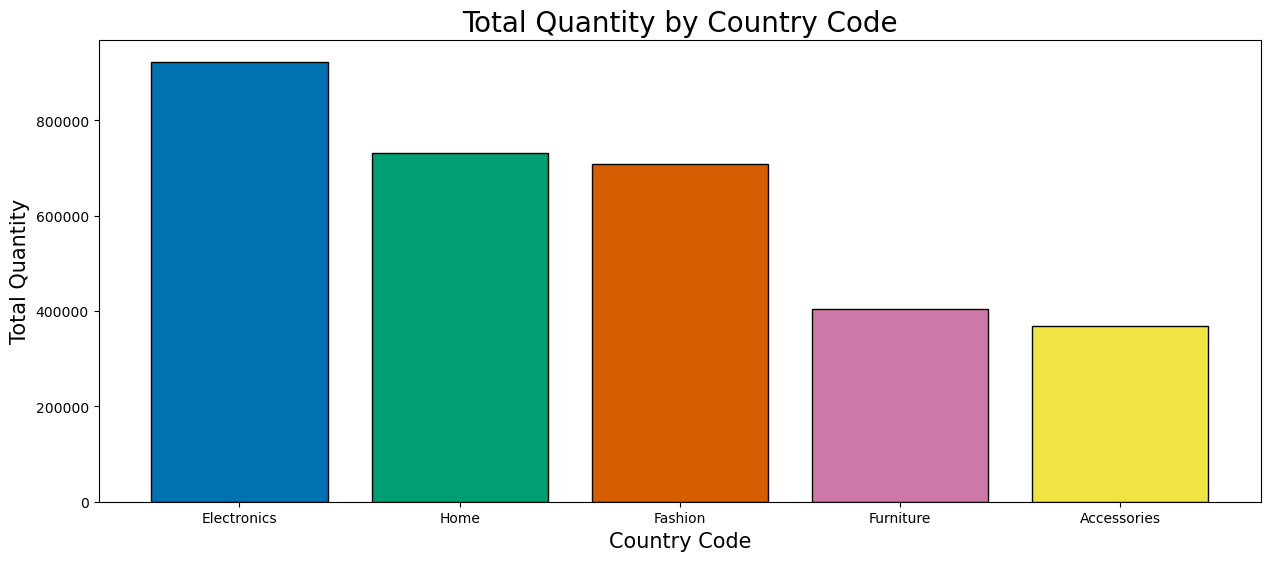

In [5]:
df_grouped = df_sales.groupby('product_category')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]

plt.figure(figsize=(15, 6))
plt.bar(df_grouped['product_category'], df_grouped['quantity'], color=colores_hex, edgecolor='black')
plt.xlabel('Country Code', fontsize = 15)
plt.ylabel('Total Quantity', fontsize = 15)
plt.title('Total Quantity by Country Code', fontsize = 20)

plt.show()

In [6]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [7]:
agg_dict = {'customer_id':['count','nunique'],'order_id':['nunique'],'product_id':'count', 'total_amount_gross':['sum','mean']}

df_sales['payment_method'] = df_sales['payment_method'].str.title().str.strip()

df_agrupado = df_sales.groupby(['payment_method','country_code'])[['customer_id','order_id','product_id','total_amount_gross']].agg(agg_dict).round(2)
df_agrupado.sort_values(by=('customer_id','count'), ascending=False).reset_index()


payment_method country_code customer_id         order_id product_id  \
                                     count nunique  nunique      count   
0     Credit Card          BRA      519057  153437   518800     519057   
1     Credit Card          MEX      212096   87793   212009     212096   
2      Debit Card          MEX      184668   84116   184567     184668   
3      Debit Card          BRA      176962  107043   176884     176962   
4      Debit Card          ARG       86625   32723    86594      86625   
5      Debit Card          COL       81898   34868    81861      81898   
6     Credit Card          COL       76146   34204    76096      76146   
7          Paypal          MEX       72222   51368    72193      72222   
8      Debit Card          PER       57757   24613    57729      57757   
9          Paypal          BRA       55586   46884    55551      55586   
10    Credit Card          ARG       54619   28072    54599      54619   
11    Credit Card          PER       53664   24035    53633      53664   
12  Bank Transfer          BRA       47056   40740    47030      47056   
13    Credit Card          CHL       39481   14596    39459      39481   
14         Paypal          COL       33423   22822    33404      33423   
15  Bank Transfer          MEX       29424   25442    29407      29424   
16    Credit Card          ECU       25879   10659    25863      25879   
17     Debit Card          CHL       25175   12634    25155      25175   
18         Paypal          ARG       23126   17035    23111      23126   
19         Paypal          PER       23061   15690    23045      23061   
20     Debit Card          ECU       22333   10206    22326      22333   
21    Credit Card          URY       20260    7490    20251      20260   
22  Bank Transfer          ARG       15336   12463    15328      15336   
23     Debit Card          URY       12991    6499    12979      12991   
24  Bank Transfer          COL        9819    8768     9812       9819   
25         Paypal          CHL        9179    6961     9175       9179   
26         Paypal          ECU        8744    6270     8737       8744   
27  Bank Transfer          PER        6962    6191     6960       6962   
28  Bank Transfer          CHL        5910    4902     5907       5910   
29         Paypal          URY        4843    3630     4840       4843   
30  Bank Transfer          ECU        3645    3116     3642       3645   
31  Bank Transfer          URY        3053    2509     3053       3053   

   total_amount_gross           
                  sum     mean  
0         263480358.0   507.61  
1         135894610.0   640.72  
2          44864521.0   242.95  
3          41573269.5   234.93  
4          16662479.0   192.35  
5          15224001.5   185.89  
6          36241807.5   475.95  
7          14753064.5   204.27  
8          10790124.0   186.82  
9           8356812.5   150.34  
10         29247383.5   535.48  
11         25534852.0   475.83  
12         36802537.0   782.10  
13         41479322.5  1050.61  
14          5260827.5   157.40  
15         23315242.0   792.39  
16         16672361.5   644.24  
17         10672587.0   423.94  
18          3200192.0   138.38  
19          3656732.0   158.57  
20          5442869.0   243.71  
21         21217918.5  1047.28  
22          6741905.5   439.61  
23          5508467.0   424.02  
24          5947823.0   605.75  
25          3203264.5   348.98  
26          1795300.0   205.32  
27          4206211.5   604.17  
28          6986256.5  1182.11  
29          1664163.5   343.62  
30          2875650.0   788.93  
31          3694497.5  1210.12

In [8]:
print((100*df_sales['shipping_status'].value_counts(normalize = True)).round(3))

shipping_status
Delivered     40.034
Shipped       29.958
Processing    20.024
Cancelled      9.984
Name: proportion, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_28596\2237363092.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis')


<Axes: xlabel='payment_method', ylabel='total_amount_gross'>

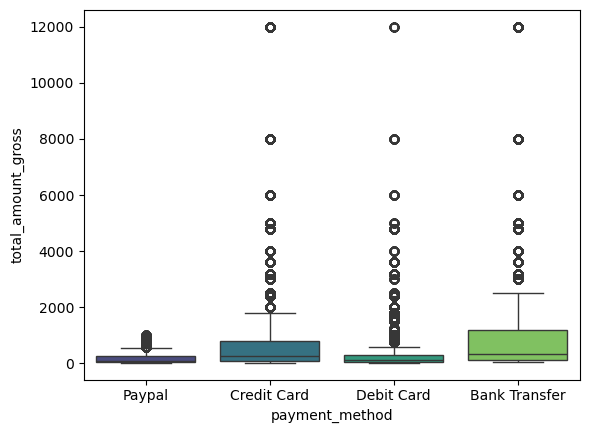

In [9]:
sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis') 

In [10]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [11]:
dimensiones = ['country_code','product_category']
metricas    = ['total_amount_gross', 'shipping_cost','discount_amount']
agg_dic     = {'total_amount_gross': ['sum','max','min','mean'],
               'shipping_cost'     : ['sum','max','min','mean'],
               'discount_amount'   : ['sum','max','min','mean']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('total_amount_gross','sum'), ascending = False)
df_grouped.reset_index().to_excel('Grouped_sales_data.xlsx', index = True)

In [12]:
diccionario = {"nombre": "Juan", "edad": 30, "ciudad": "Madrid"}

x = (2,4)
x[1]

4

In [13]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [14]:
df_sales.describe()

,customer_id,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount
count,2.001000e+06,2.001000e+06,1.996997e+06,1.999000e+06,1.990994e+06,2.001000e+06,2.001000e+06,1.980987e+06,2.001000e+06
mean,2.010431e+05,1.567433e+00,2.712772e+02,8.650055e+00,1.797527e+01,4.262706e+02,1.493294e+01,7.816253e+01,5.062121e+02
std,1.154634e+05,1.216294e+00,3.186014e+02,1.999451e+01,2.999350e+01,7.141159e+02,5.036862e+01,1.312087e+02,8.338553e+02
min,1.000000e+03,-1.000000e+01,2.000000e+01,1.000000e-01,5.150000e+00,2.000000e+01,0.000000e+00,3.040000e+00,1.217000e+01
25%,1.010940e+05,1.000000e+00,4.500000e+01,6.000000e-01,5.900000e+00,7.000000e+01,0.000000e+00,1.292000e+01,8.697000e+01
50%,2.010700e+05,1.000000e+00,1.200000e+02,2.200000e+00,8.300000e+00,1.500000e+02,0.000000e+00,2.850000e+01,1.985000e+02
75%,3.010172e+05,2.000000e+00,3.000000e+02,1.000000e+01,2.000000e+01,5.000000e+02,8.500000e+00,9.500000e+01,6.052500e+02
max,4.009990e+05,1.000000e+01,1.200000e+03,4.500000e+02,6.800000e+02,1.200000e+04,2.400000e+03,2.280000e+03,1.432250e+04


In [15]:
df_sales.isna().sum()

order_id                   0
order_date                 0
customer_id                0
customer_name              0
customer_email        100044
customer_country           0
country_code               0
customer_city          40017
customer_address           0
product_id                 0
product_name               0
product_category           0
quantity                   0
price_per_unit          4003
total_weight            2000
shipping_cost          10006
total_amount_gross         0
discount_amount            0
tax_amount             20013
final_total_amount         0
payment_method             0
shipping_status       200094
dtype: int64

In [16]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [17]:
dimensiones = ['country_code']


metricas    = ['quantity',
                'total_amount_gross',
                'shipping_cost',
                'discount_amount',
                'price_per_unit',
                'total_weight',
                'tax_amount',
                'final_total_amount',
                'order_id','customer_id']


agg_dic     = { 'quantity'          : ['sum','max','min','mean'],
                'total_amount_gross': ['sum','max','min','mean'],
                'shipping_cost'     : ['sum','max','min','mean'],
                'discount_amount'   : ['sum','max','min','mean'],
                'price_per_unit'    : ['sum','max','min','mean'],
                'total_weight'      : ['sum','max','min','mean'],
                'tax_amount'        : ['sum','max','min','mean'],
                'final_total_amount': ['sum','max','min','mean'],
                'order_id'          : ['count','nunique'],
                'customer_id'       : ['count','nunique']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('final_total_amount','sum'), ascending = False)
df_grouped.reset_index()

country_code quantity                   total_amount_gross                 \
                    sum max min      mean                sum      max   min   
0          BRA  1251177  10 -10  1.566593        350212977.0  12000.0  20.0   
1          MEX   781113  10 -10  1.567210        218827437.5  12000.0  20.0   
2          COL   316094  10 -10  1.570373         62674459.5  12000.0  20.0   
3          CHL   124893  10 -10  1.566155         62341430.5  12000.0  20.0   
4          ARG   281692  10 -10  1.567516         55851960.0  12000.0  20.0   
5          PER   222077  10 -10  1.570070         44187919.5  12000.0  20.0   
6          URY    64383  10  -4  1.564707         32085046.5  12000.0  20.0   
7          ECU    95005  10 -10  1.567713         26786180.5  12000.0  20.0   

              shipping_cost                         discount_amount          \
         mean           sum    max   min       mean             sum     max   
0  438.500161   15339424.75  680.0  5.15  19.303931    1.223914e+07  2400.0   
1  439.051057    9571588.65  680.0  5.15  19.301332    7.658035e+06  2400.0   
2  311.370187    3063487.95  680.0  5.15  15.297400    2.217057e+06  2400.0   
3  781.759740    1123771.40  680.0  5.15  14.162032    2.185388e+06  2400.0   
4  310.796301    2746503.55  680.0  5.15  15.359040    1.972308e+06  2400.0   
5  312.405754    2182391.15  680.0  5.15  15.504232    1.547500e+06  2400.0   
6  779.766362     581603.40  680.0  5.15  14.199648    1.109256e+06  2400.0   
7  442.008886    1179892.30  680.0  5.15  19.563468    9.521381e+05  2400.0   

                  price_per_unit                           total_weight  \
   min       mean            sum     max   min        mean          sum   
0  0.0  15.324573    222670921.5  1200.0  20.0  279.380041    7609607.4   
1  0.0  15.364930    138769571.5  1200.0  20.0  278.983160    4747244.5   
2  0.0  11.014462     39818061.5  1200.0  20.0  198.209267    1379659.1   
3  0.0  27.404699     39603404.0  1200.0  20.0  497.586461     487278.2   
4  0.0  10.975193     35459830.0  1200.0  20.0  197.706405    1238677.7   
5  0.0  10.940724     28056005.5  1200.0  20.0  198.713811     989681.4   
6  0.0  26.958375     20378723.0  1200.0  20.0  496.400336     252141.9   
7  0.0  15.711591     16983197.0  1200.0  20.0  280.760407     587169.4   

                           tax_amount                            \
     max  min      mean           sum     max   min        mean   
0  450.0  0.1  9.537116  6.357666e+07  2280.0  3.04   80.418044   
1  450.0  0.1  9.534706  3.971862e+07  2280.0  3.04   80.499846   
2  450.0  0.1  6.861142  1.137896e+07  2280.0  3.04   57.091463   
3  450.0  0.1  6.116975  1.131134e+07  2280.0  3.04  143.303001   
4  450.0  0.1  6.900365  1.013995e+07  2280.0  3.04   57.000606   
5  450.0  0.1  7.003768  8.024094e+06  2280.0  3.04   57.278137   
6  450.0  0.1  6.134093  5.827748e+06  2280.0  3.04  142.991167   
7  450.0  0.1  9.697105  4.861580e+06  2280.0  3.04   80.988531   

  final_total_amount                             order_id         customer_id  \
                 sum      max    min        mean    count nunique       count   
0       4.165422e+08  14322.5  12.17  521.550641   798661  798265      798661   
1       2.602793e+08  14322.5  12.17  522.219159   498410  498176      498410   
2       7.485321e+07  14322.5  12.17  371.874880   201286  201173      201286   
3       7.252474e+07  14322.5  13.36  909.458106    79745   79696       79745   
4       6.672660e+07  14322.5  12.17  371.309810   179706  179632      179706   
5       5.280551e+07  14322.5  12.17  373.331571   141444  141367      141444   
6       3.734255e+07  14322.5  13.36  907.540135    41147   41123       41147   
7       3.185647e+07  14322.5  13.36  525.675722    60601   60568       60601   

           
  nunique  
0  158574  
1   99094  
2   39898  
3   15821  
4   35740  
5   28051  
6    8106  
7   12015

In [18]:
df_sales[df_sales.duplicated(keep = False)].sort_values(by = 'order_id', ascending = False).head(2)

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
2000824,fee5cf1a-f42b-4af7-bf45-0df4d87b641b,2025-12-06,56945,Juan Torres,juan.torres_56945@example.com,Colombia,COL,Medellín,5501 Calle Este,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,2.25,8.1225,56.6225,Paypal,Cancelled
1442326,fee5cf1a-f42b-4af7-bf45-0df4d87b641b,2025-12-06,56945,Juan Torres,juan.torres_56945@example.com,Colombia,COL,Medellín,5501 Calle Este,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,2.25,8.1225,56.6225,Paypal,Cancelled


In [19]:
df_sales.drop_duplicates(keep = 'first', inplace = True)

In [20]:
df_sales['quantity'] = df_sales['quantity'].abs()

In [21]:
df_sales[df_sales['quantity'] < 0]

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status


In [22]:
df_sales.dtypes

order_id               object
order_date             object
customer_id             int32
customer_name          object
customer_email         object
customer_country       object
country_code           object
customer_city          object
customer_address       object
product_id             object
product_name           object
product_category       object
quantity                int32
price_per_unit        float64
total_weight          float64
shipping_cost         float64
total_amount_gross    float64
discount_amount       float64
tax_amount            float64
final_total_amount    float64
payment_method         object
shipping_status        object
dtype: object

In [23]:
df_sales.head()

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
0,ea66275b-035f-455e-8f49-008d57ee2f40,2024-10-30,6081,Benjamín Torres,benjamín.torres_6081@example.com,México,MEX,Juárez,3668 Calle Sur,P020,Backpack,Accessories,1,55.0,0.4,5.6,55.0,0.0,10.45,71.05,Paypal,Processing
1,a8df70a4-9ccb-4a39-ba4b-41aa88696563,2024-07-05,6516,Felipe Gutierrez,felipe.gutierrez_6516@example.com,Colombia,COL,Bucaramanga,3348 Calle Oeste,P010,T-Shirt,Fashion,1,20.0,0.2,5.3,20.0,0.0,3.80,29.10,Credit Card,Cancelled
2,f60b9d08-300e-4c37-a288-525887dd57df,2024-04-02,78808,Miguel Gomez,miguel.gomez_78808@example.com,Chile,CHL,Rancagua,2514 Calle Sur,P011,Smart TV 55in,Electronics,1,600.0,12.0,23.0,600.0,60.0,102.60,665.60,Credit Card,Delivered
3,3e6e2d04-c0ec-4ecc-9b77-e476a131ce4f,2024-08-16,181298,Santiago Flores,santiago.flores_181298@example.com,Brasil,BRA,São Paulo,678 Calle Los Alamos,P011,Smart TV 55in,Electronics,1,600.0,12.0,23.0,600.0,0.0,114.00,737.00,Credit Card,Shipped
4,a9ad5c18-d343-41f6-b958-e7b235a3e69a,2024-12-02,344203,Benjamín Flores,benjamín.flores_344203@example.com,México,MEX,Tijuana,804 Calle Norte,P007,Blender,Home,2,45.0,4.4,11.6,90.0,0.0,17.10,118.70,Credit Card,Delivered


In [ ]:
df_sales.head()

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
0,ea66275b-035f-455e-8f49-008d57ee2f40,2024-10-30,6081,Benjamín Torres,benjamín.torres_6081@example.com,México,MEX,Juárez,3668 Calle Sur,P020,Backpack,Accessories,1,55.0,0.4,5.6,55.0,0.0,10.45,71.05,Paypal,Processing
1,a8df70a4-9ccb-4a39-ba4b-41aa88696563,2024-07-05,6516,Felipe Gutierrez,felipe.gutierrez_6516@example.com,Colombia,COL,Bucaramanga,3348 Calle Oeste,P010,T-Shirt,Fashion,1,20.0,0.2,5.3,20.0,0.0,3.80,29.10,Credit Card,Cancelled
2,f60b9d08-300e-4c37-a288-525887dd57df,2024-04-02,78808,Miguel Gomez,miguel.gomez_78808@example.com,Chile,CHL,Rancagua,2514 Calle Sur,P011,Smart TV 55in,Electronics,1,600.0,12.0,23.0,600.0,60.0,102.60,665.60,Credit Card,Delivered
3,3e6e2d04-c0ec-4ecc-9b77-e476a131ce4f,2024-08-16,181298,Santiago Flores,santiago.flores_181298@example.com,Brasil,BRA,São Paulo,678 Calle Los Alamos,P011,Smart TV 55in,Electronics,1,600.0,12.0,23.0,600.0,0.0,114.00,737.00,Credit Card,Shipped
4,a9ad5c18-d343-41f6-b958-e7b235a3e69a,2024-12-02,344203,Benjamín Flores,benjamín.flores_344203@example.com,México,MEX,Tijuana,804 Calle Norte,P007,Blender,Home,2,45.0,4.4,11.6,90.0,0.0,17.10,118.70,Credit Card,Delivered


In [25]:
df_sales[df_sales['order_date'].isna()].shape

(0, 22)

In [26]:
dimensiones = ['shipping_status']


metricas    = ['quantity',
                'total_amount_gross',
                'shipping_cost',
                'discount_amount',
                'price_per_unit',
                'total_weight',
                'tax_amount',
                'final_total_amount',
                'order_id','customer_id']


agg_dic     = { 'quantity'          : ['sum','max','min','mean'],
                'total_amount_gross': ['sum','max','min','mean'],
                'shipping_cost'     : ['sum','max','min','mean'],
                'discount_amount'   : ['sum','max','min','mean'],
                'price_per_unit'    : ['sum','max','min','mean'],
                'total_weight'      : ['sum','max','min','mean'],
                'tax_amount'        : ['sum','max','min','mean'],
                'final_total_amount': ['sum','max','min','mean'],
                'order_id'          : ['count','nunique'],
                'customer_id'       : ['count','nunique']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('final_total_amount','sum'), ascending = False)
df_grouped.reset_index()

shipping_status quantity                   total_amount_gross           \
                       sum max min      mean                sum      max   
0       Delivered  1133842  10   1  1.573489        307453066.5  12000.0   
1         Shipped   845886  10   1  1.568541        230350494.0  12000.0   
2      Processing   565077  10   1  1.567873        153232337.0  12000.0   
3       Cancelled   281472  10   1  1.566196         75978508.0  12000.0   

                    shipping_cost                         discount_amount  \
    min        mean           sum    max   min       mean             sum   
0  20.0  426.667925    12893856.3  680.0  5.15  17.983665    1.080140e+07   
1  20.0  427.142931     9630676.6  680.0  5.15  17.948593    8.074981e+06   
2  20.0  425.161169     6437266.7  680.0  5.15  17.949905    5.346340e+06   
3  20.0  422.767507     3213778.8  680.0  5.15  17.969330    2.646850e+06   

                          price_per_unit                            \
      max  min       mean            sum     max   min        mean   
0  2400.0  0.0  14.989643    195041266.5  1200.0  20.0  271.212713   
1  2400.0  0.0  14.973578    146266827.5  1200.0  20.0  271.784536   
2  2400.0  0.0  14.834049     97441488.5  1200.0  20.0  270.898808   
3  2400.0  0.0  14.727879     48510622.0  1200.0  20.0  270.444000   

  total_weight                          tax_amount                           \
           sum    max  min      mean           sum     max   min       mean   
0    6231046.8  450.0  0.1  8.655626  5.582101e+07  2280.0  3.04  78.243803   
1    4649730.7  450.0  0.1  8.631007  4.180751e+07  2280.0  3.04  78.303097   
2    3108436.3  450.0  0.1  8.633274  2.781554e+07  2280.0  3.04  77.967096   
3    1551732.5  450.0  0.1  8.643642  1.380139e+07  2280.0  3.04  77.554205   

  final_total_amount                             order_id         customer_id  \
                 sum      max    min        mean    count nunique       count   
0       3.651065e+08  14322.5  12.17  506.676395   720591  720591      720591   
1       2.734986e+08  14322.5  12.17  507.153250   539282  539282      539282   
2       1.820128e+08  14322.5  12.17  505.015851   360410  360410      360410   
3       9.025303e+07  14322.5  12.17  502.195294   179717  179717      179717   

           
  nunique  
0  333552  
1  296015  
2  237398  
3  144859

In [29]:
df_sales['shipping_status'].value_counts(dropna = False)

shipping_status
Delivered     720591
Shipped       539282
Processing    360410
NaN           200000
Cancelled     179717
Name: count, dtype: int64

In [28]:
df_sales[df_sales['shipping_status'].isna()].head(10)

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
7,aa7e4d8c-a74e-405d-89b6-77fd1f3d5d32,2025-07-09,170521,Raquel López,raquel.lópez_170521@example.com,Chile,CHL,Santiago,8911 Calle Norte,P004,Mechanical Keyboard,Accessories,2,150.0,2.4,8.60,300.0,0.0,57.00,365.60,Credit Card,NaN
8,a1f50efa-2378-4eb3-b4d0-31cff19131e6,2025-07-21,283734,Raquel Pérez,raquel.pérez_283734@example.com,Chile,CHL,Santiago,1466 Calle Los Pinos,P008,Office Chair,Furniture,1,200.0,15.0,27.50,200.0,0.0,38.00,265.50,Debit Card,NaN
10,3510c786-423c-4495-8de6-8084cc9db136,2024-12-28,20614,Isabel Castro,isabel.castro_20614@example.com,Uruguay,URY,Maldonado,2548 Calle Este,P012,Headphones NoiseCancelling,Electronics,2,250.0,0.6,5.90,500.0,0.0,95.00,600.90,Debit Card,NaN
22,658baa99-59b1-4c40-9a2d-bcb8989067c4,2025-06-12,52241,David Rodríguez,david.rodríguez_52241@example.com,Brasil,BRA,Salvador,5574 Calle Secundaria,P014,Microwave Oven,Home,1,150.0,10.0,20.00,150.0,0.0,28.50,198.50,Credit Card,NaN
36,be76b461-a2a3-4d80-bff5-014ee16016ca,2025-10-15,207190,Elena Torres,elena.torres_207190@example.com,Colombia,COL,Bogotá,7467 Calle Oeste,P010,T-Shirt,Fashion,2,20.0,0.4,5.60,40.0,0.0,7.60,53.20,Debit Card,NaN
40,d80b1c86-537e-4b0d-8c17-a25aa281d55d,2025-06-30,336894,Mateo Flores,mateo.flores_336894@example.com,Brasil,BRA,NaN,3959 Calle Los Pinos,P009,Running Shoes,Fashion,1,120.0,0.8,6.20,120.0,6.0,21.66,141.86,Paypal,NaN
50,9fac2ae6-da22-4ae8-a8a5-b0d1a5555e5a,2024-06-08,247852,Isabel Silva,isabel.silva_247852@example.com,Brasil,BRA,Fortaleza,3818 Calle Principal,P005,Monitor 27in,Electronics,2,300.0,10.0,20.00,600.0,0.0,114.00,734.00,Paypal,NaN
54,798ab9dd-9a8f-449a-8b10-6afdcf15b138,2025-01-17,348118,Lucía Flores,lucía.flores_348118@example.com,Chile,CHL,Concepción,4916 Calle Los Alamos,P011,Smart TV 55in,Electronics,1,600.0,12.0,23.00,600.0,0.0,114.00,737.00,Credit Card,NaN
58,bd9a89b9-c175-42cd-8b6c-4fe998afeaa8,2025-03-11,288415,Luisa Flores,luisa.flores_288415@example.com,Argentina,ARG,Mar del Plata,742 Calle Este,P001,Laptop Pro,Electronics,3,1200.0,7.5,16.25,3600.0,0.0,684.00,4300.25,Credit Card,NaN
63,1b4ecb14-ca0d-4f45-8149-a7f261a83507,2025-07-31,75000,Sofía Gutierrez,sofía.gutierrez_75000@example.com,Perú,PER,Cusco,9814 Calle Sur,P010,T-Shirt,Fashion,3,20.0,0.6,5.90,60.0,3.0,10.83,73.73,Credit Card,NaN


In [30]:
df_sales.isna().sum()

order_id                   0
order_date                 0
customer_id                0
customer_name              0
customer_email        100000
customer_country           0
country_code               0
customer_city          40000
customer_address           0
product_id                 0
product_name               0
product_category           0
quantity                   0
price_per_unit          4000
total_weight            2000
shipping_cost          10000
total_amount_gross         0
discount_amount            0
tax_amount             20000
final_total_amount         0
payment_method             0
shipping_status       200000
dtype: int64